# Tema 7: Transformada de Hough

En este cuaderno se explicarán algunas de las aplicaciones de la Transformada de Hough y específicamente su implementación en código.

**Objetivos:**

* Comprensión del fundamento mátematico de la Transformada de Hough.
* Utilización de librerías de Python abiertas para el análisis de imágenes (scikit-image, OpenCV)
* Implementación de diferentes funciones para la detección de líneas y circunferencias.

### ¿Qué es la Tranformada de Hough?

La ecuación de la recta normalmente se compone de los siguientes parámetros:
#### y = mx + b

En donde **m** es la pendiente y **b** es la intersección

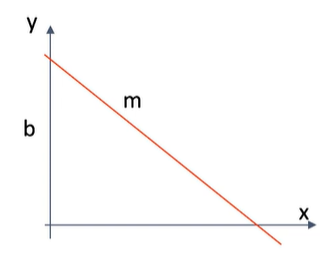

La línea también puede ser representada como:

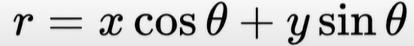

En donde **r** es la distancia desde el origen al punto más cercano de la línea recta.

**(r, θ)** corresponde al espacio de Hough que representa la línea.

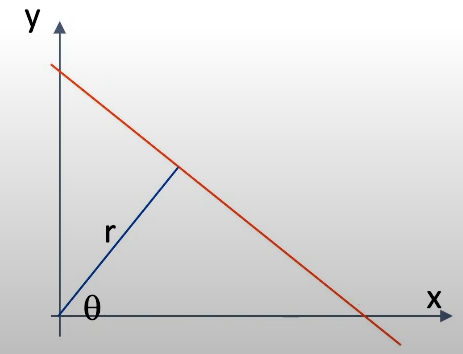

La representación anterior le permite al algoritmo considerar los parámetros de ángulo y distancia para así buscar la línea recta que mejor se ajusta a los puntos en el plano.

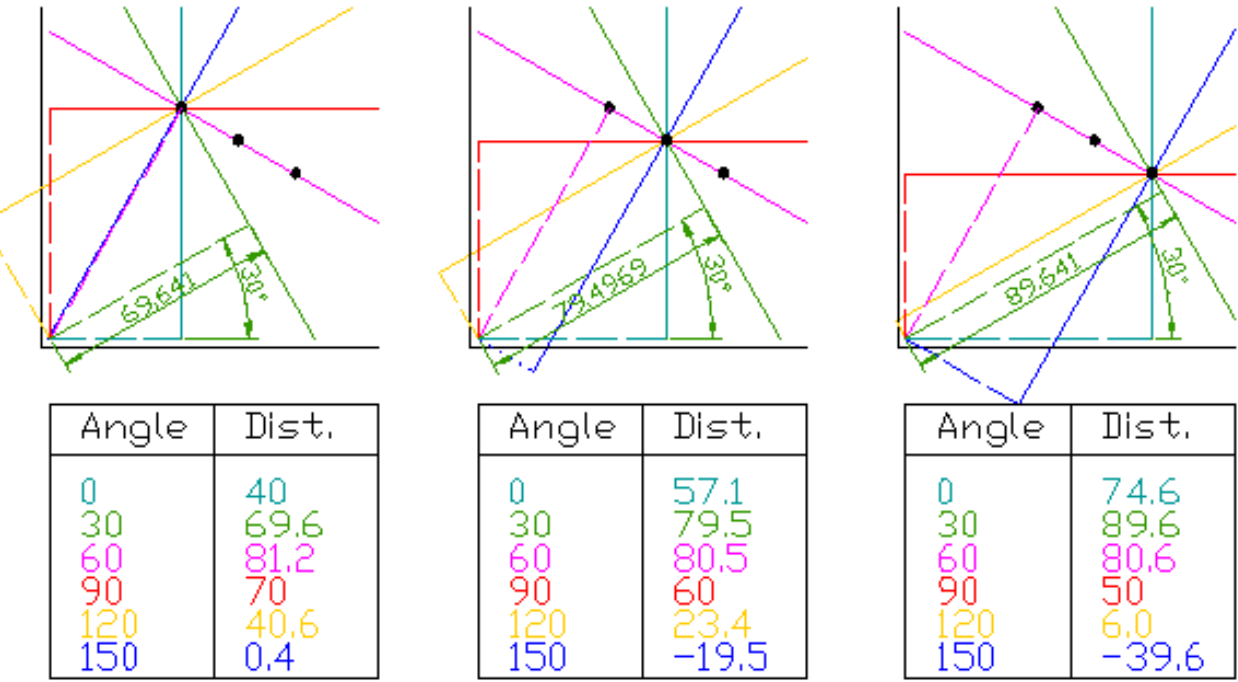

### Implementación usando scikit-image

In [21]:
from skimage.transform import hough_line, hough_line_peaks
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import math

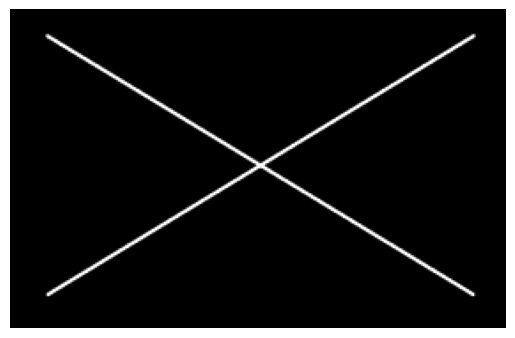

In [11]:
imagen = cv2.imread("lineas.png", 0)
imagen = ~imagen
plt.imshow(imagen, cmap="gray")
plt.axis("off");

In [12]:
# Dividimos el espacio de datos en 180 puntos

angulos = np.linspace(-np.pi/2, np.pi/2, 180)
len(angulos)

180

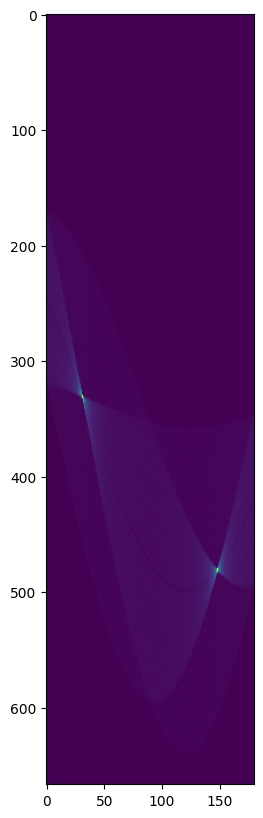

In [13]:
hspace, theta, dist = hough_line(imagen, angulos)

plt.figure(figsize=(10,10))
plt.imshow(hspace);

In [14]:
# Ahora para conocer la localización de los picos en el espacio de hough podemos utilizar la función hough_line_peaks()

h, q, d = hough_line_peaks(hspace, theta, dist)

In [15]:
df = pd.DataFrame({"Hough Space": h, "Angles": q, "Distance": d})

In [16]:
df.head()

,Hough Space,Angles,Distance
0,285,-1.026722,-2.0
1,283,1.026722,149.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hough Space  2 non-null      uint64 
 1   Angles       2 non-null      float64
 2   Distance     2 non-null      float64
dtypes: float64(2), uint64(1)
memory usage: 176.0 bytes


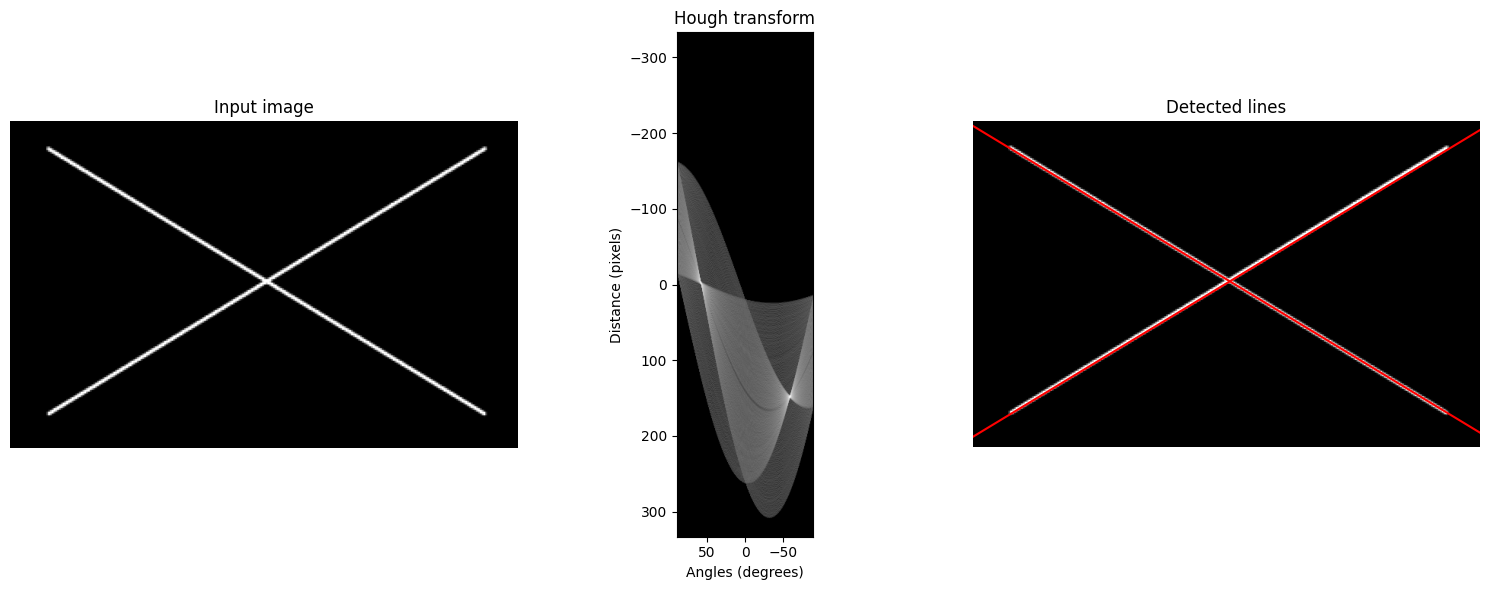

In [18]:
# Ejemplo de la documentación de skimage
angle_list=[] 

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(imagen, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + hspace),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), dist[-1], dist[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(imagen, cmap='gray')

origin = np.array((0, imagen.shape[1]))

for _, angle, dist in zip(*hough_line_peaks(hspace, theta, dist)):
    angle_list.append(angle) 
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((imagen.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

### Implementación usando OpenCV

In [36]:
imagen_prueba = cv2.imread("tablero.jpg", 0)
dst = cv2.Canny(imagen_prueba, 50, 200, None, 3)

cdst = cv2.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)
lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

In [37]:
len(lines)

29

In [40]:
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)

In [50]:
def mostrar_imagenes(imagen_original, imagen_lineas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    ax1.imshow(imagen_original, cmap="gray")
    ax2.imshow(imagen_lineas)
    ax1.set_title("Imagen original")
    ax2.set_title("Tranformada de Hough")
    ax1.axis('off')
    ax2.axis('off');

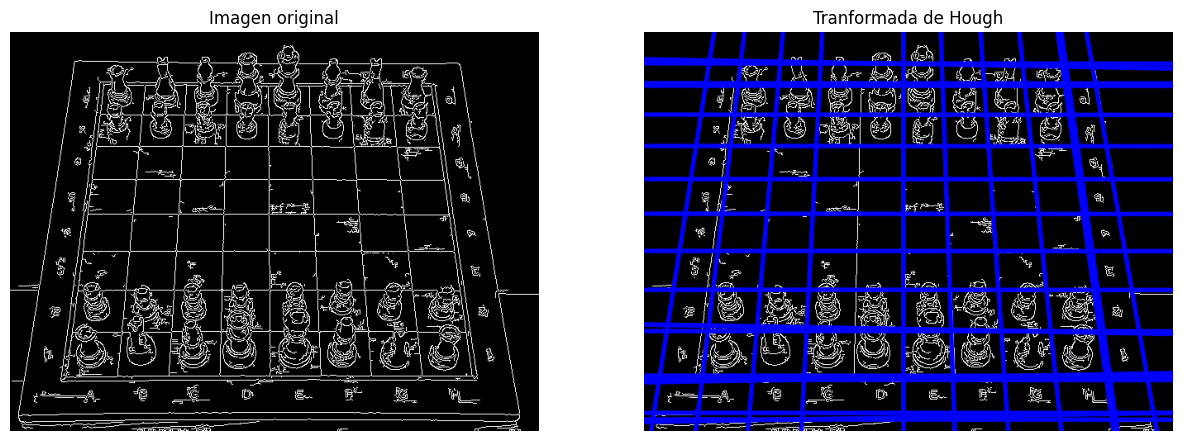

In [51]:
mostrar_imagenes(dst, cdst)

**Referencias:**

[1] Straight line hough transform#. Straight line Hough transform - skimage 0.21.0 documentation. (n.d.). https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html#sphx-glr-auto-examples-edges-plot-line-hough-transform-py 

[2] Hough Line transform. OpenCV. (n.d.-b). https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html 